# I. Librairies

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.0.0
Num GPUs Available: 1


In [3]:
from generalBDDHandler import GeneralBDDHandler
from generalIOLib import FlatInputDic

In [4]:
random_seed = 42

# II. Data

### II.A General IO

In [5]:
bdd_handler = GeneralBDDHandler()
general_bdd = pd.read_csv('datasets/generalIO_v2.csv', delimiter = ";")
general_bdd['units_list'] = general_bdd['units_list'].apply(bdd_handler.convertUnitsList)
general_bdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121536 entries, 0 to 121535
Data columns (total 11 columns):
match_id      121536 non-null int64
flipped       121536 non-null bool
units_list    121536 non-null object
p1_health     121536 non-null float64
p1_cores      121536 non-null float64
p1_bits       121536 non-null float64
p2_health     121536 non-null float64
p2_cores      121536 non-null float64
p2_bits       121536 non-null float64
turn          121536 non-null int64
output        121536 non-null object
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 9.4+ MB


In [6]:
general_bdd.head()

,match_id,flipped,units_list,p1_health,p1_cores,p1_bits,p2_health,p2_cores,p2_bits,turn,output
0,5635542,False,(),30.0,40.0,5.0,30.0,40.0,5.0,0,14_4_1
1,5635542,False,"((14, 4, 1, 30.0),)",30.0,36.0,5.0,30.0,40.0,5.0,0,0_13_0
2,5635542,False,"((14, 4, 1, 30.0), (0, 13, 0, 60.0))",30.0,35.0,5.0,30.0,40.0,5.0,0,1_13_0
3,5635542,False,"((14, 4, 1, 30.0), (0, 13, 0, 60.0), (1, 13, 0...",30.0,34.0,5.0,30.0,40.0,5.0,0,1_13_6
4,5635542,False,"((14, 4, 1, 30.0), (0, 13, 0, 60.0), (1, 13, 0...",30.0,34.0,5.0,30.0,40.0,5.0,0,2_13_0


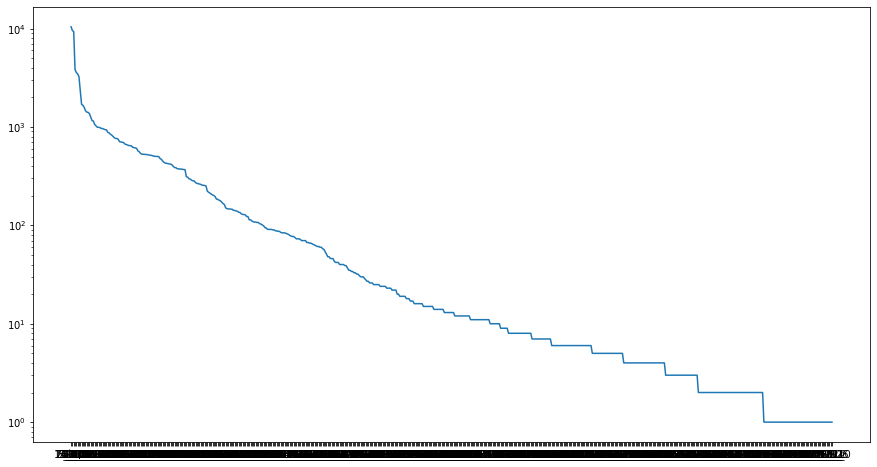

In [7]:
# output class representation

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)

ax.plot(general_bdd['output'].value_counts(), label = 'member count per class')

ax.set_yscale('log')
plt.show()

### II.B Train/Test/Validation separation

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
inputs = general_bdd[['units_list', 'p1_health', 'p1_cores',
                      'p1_bits', 'p2_health', 'p2_cores', 'p2_bits', 'turn']].values
outputs = general_bdd['output'].values

improvement: stratify the data, it is impossible for now as some outputs have too few members

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(inputs, outputs, train_size = 0.8,test_size = 0.2,
                                                            random_state = random_seed, shuffle = True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size = 0.8,test_size = 0.2,
                                                            random_state = random_seed, shuffle = True)
print(X_train.shape, X_test.shape, X_validation.shape)

(77782, 8) (19446, 8) (24308, 8)


### II.C Images loading

This take forever so thats why we should find a way to make a tensorflow generator (and also to learn on much more data)

In [11]:
def getImages(X):
    general_bdd_handler = GeneralBDDHandler()
    image_units_list = X[:,0]
    images = general_bdd_handler.getImages(image_units_list)
    return X[:,1:], images

In [12]:
X_train, images_train = getImages(X_train)
X_test, images_test = getImages(X_test)
X_validation, images_validation = getImages(X_validation)

100%|██████████| 24308/24308 [00:06<00:00, 3636.24it/s]


In [13]:
X_train, X_test, X_validation = X_train.astype('float'), X_test.astype('float'), X_validation.astype('float')
images_train, images_test, images_validation = images_train.astype('float'),  images_test.astype('float') , images_validation.astype('float')

In [13]:
print(X_train.shape, X_test.shape, X_validation.shape)
print(images_train.shape, images_test.shape, images_validation.shape)

(25700, 7) (6425, 7) (8032, 7)
(25700, 15, 29, 7) (6425, 15, 29, 7) (8032, 15, 29, 7)


### II.D Outputs Construction

The outputs construction is pretty fast so that's good (maybe we should use the same "construct on the spot" technic for the inputs)

In [14]:
outputLib = OutputLib([chosen_eagle])

In [15]:
y_train = outputLib.constructOutputs(y_train)
y_test = outputLib.constructOutputs(y_test)
y_validation = outputLib.constructOutputs(y_validation)

25700it [00:00, 737045.30it/s]
6425it [00:00, 989549.56it/s]
8032it [00:00, 1138553.17it/s]


In [16]:
print(y_train.shape, y_test.shape, y_validation.shape)

(25700, 132) (6425, 132) (8032, 132)


### II.E Normalisation

In [17]:
X_train = X_train / 30
X_validation = X_validation / 30
X_test = X_test / 30

# III Model

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten, Conv2D, Activation, MaxPooling2D, BatchNormalization,concatenate
from tensorflow.keras.optimizers import Adam

In [21]:
dropout_rate = 0.2

def createMLP(input_dim):
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation="relu"))
    model.add(Dense(8, activation="relu"))
    return model

def createCNN(width, height, depth, filters = (16,32,64)):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        #x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2,2 ),padding="same")(x)
        x = Dropout(dropout_rate)(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [22]:
mlp = createMLP(FlatInputDic().index)
cnn = createCNN(29,15,7, filters = (16,32,64))

combinedInput = concatenate([mlp.output, cnn.output])
x = Dense(outputLib.index, activation="relu")(combinedInput)
x = Dropout(dropout_rate)(x)
x = Dense(outputLib.index)(x)
x = Activation('softmax')(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = Adam(lr=1e-3) #decay=1e-3 / 200
model.compile(loss="categorical_crossentropy", metrics =['accuracy'], optimizer=opt)

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True, to_file='model.png')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 29, 7)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 29, 16)   1024        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 15, 29, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 15, 16)    0           activation[0][0]                 
____________________________________________________________________________________________

# IV Training

For the training, I have always done it "by hand", it could be worth to look into TensorBoard

In [24]:
train_acc_list = []
train_loss_list = []
validation_acc_list = []
validation_loss_list = []

In [25]:
n_epochs = 200
for i in range(n_epochs):
    
    history = model.fit([X_train, images_train],y_train,validation_data=[[X_validation, images_validation], y_validation], batch_size=1024, epochs=1, verbose = 0)
    train_loss, train_acc, validation_loss, validation_acc = [h[0] for h in history.history.values()]
    
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    validation_acc_list.append(validation_acc)
    validation_loss_list.append(validation_loss)
    print('{}: accuracy: {:.3f} {:.3f}, loss: {:.3f} {:.3f}'.format(i,train_acc, validation_acc, train_loss, validation_loss))

0: accuracy: 0.062 0.109, loss: 4.381 4.074
1: accuracy: 0.079 0.147, loss: 4.082 4.004
2: accuracy: 0.099 0.145, loss: 3.957 3.791
3: accuracy: 0.145 0.200, loss: 3.677 3.448
4: accuracy: 0.186 0.214, loss: 3.428 3.226
5: accuracy: 0.206 0.262, loss: 3.231 3.034
6: accuracy: 0.228 0.260, loss: 3.077 2.878
7: accuracy: 0.247 0.322, loss: 2.941 2.719
8: accuracy: 0.269 0.340, loss: 2.812 2.577
9: accuracy: 0.284 0.361, loss: 2.694 2.453
10: accuracy: 0.304 0.386, loss: 2.589 2.345
11: accuracy: 0.317 0.401, loss: 2.498 2.261
12: accuracy: 0.331 0.422, loss: 2.410 2.181
13: accuracy: 0.347 0.427, loss: 2.336 2.108
14: accuracy: 0.363 0.458, loss: 2.271 2.040
15: accuracy: 0.371 0.451, loss: 2.208 1.991
16: accuracy: 0.386 0.474, loss: 2.148 1.928
17: accuracy: 0.397 0.492, loss: 2.101 1.880
18: accuracy: 0.403 0.504, loss: 2.057 1.833
19: accuracy: 0.417 0.510, loss: 2.004 1.783
20: accuracy: 0.432 0.520, loss: 1.958 1.756
21: accuracy: 0.434 0.526, loss: 1.926 1.704
22: accuracy: 0.445 

181: accuracy: 0.726 0.775, loss: 0.825 0.736
182: accuracy: 0.727 0.766, loss: 0.816 0.746
183: accuracy: 0.721 0.778, loss: 0.824 0.740
184: accuracy: 0.730 0.777, loss: 0.815 0.740
185: accuracy: 0.729 0.781, loss: 0.811 0.731
186: accuracy: 0.730 0.779, loss: 0.801 0.740
187: accuracy: 0.725 0.778, loss: 0.814 0.737
188: accuracy: 0.727 0.777, loss: 0.814 0.736
189: accuracy: 0.729 0.780, loss: 0.805 0.729
190: accuracy: 0.732 0.778, loss: 0.799 0.736
191: accuracy: 0.733 0.779, loss: 0.803 0.729
192: accuracy: 0.729 0.780, loss: 0.797 0.730
193: accuracy: 0.733 0.777, loss: 0.800 0.730
194: accuracy: 0.731 0.781, loss: 0.810 0.723
195: accuracy: 0.732 0.780, loss: 0.797 0.727
196: accuracy: 0.735 0.783, loss: 0.790 0.720
197: accuracy: 0.731 0.782, loss: 0.797 0.722
198: accuracy: 0.735 0.779, loss: 0.794 0.723
199: accuracy: 0.733 0.779, loss: 0.792 0.722


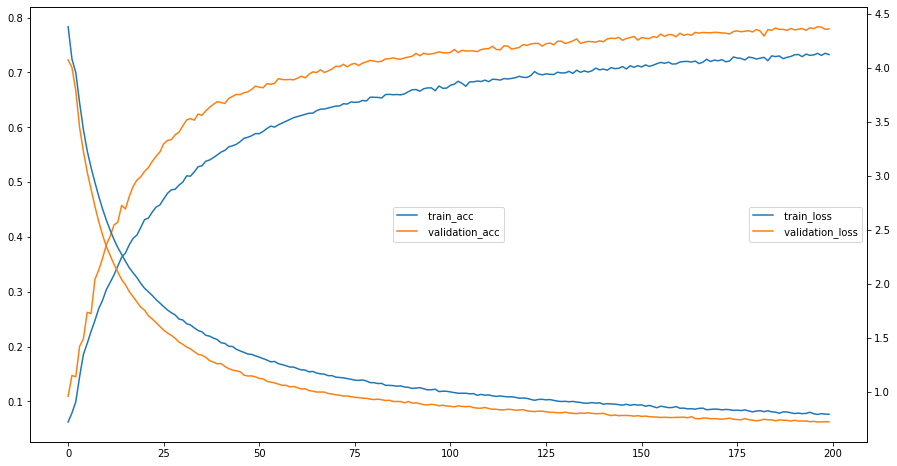

In [26]:
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()

ax1.plot(train_acc_list, label= ' train_acc')
ax1.plot(validation_acc_list, label = ' validation_acc')

ax2.plot(train_loss_list, label = ' train_loss')
ax2.plot(validation_loss_list, label = ' validation_loss')

ax1.legend(loc=10)
ax2.legend(loc=7)
plt.show()

# V Results

In [27]:
from sklearn.metrics import classification_report
train_corr_matrix = np.zeros((outputLib.index, outputLib.index))
validation_corr_matrix = np.zeros((outputLib.index, outputLib.index))
test_corr_matrix = np.zeros((outputLib.index, outputLib.index))

y_true = [np.argmax(y) for y in y_train]
y_pred = model.predict([X_train, images_train])
y_pred = [np.argmax(y) for y in y_pred]
for o1,o2 in zip(y_true,y_pred):
    train_corr_matrix[o1][o2] += 1

    
y_true = [np.argmax(y) for y in y_validation]
y_pred = model.predict([X_validation, images_validation])
y_pred = [np.argmax(y) for y in y_pred]
for o1,o2 in zip(y_true,y_pred):
    validation_corr_matrix[o1][o2] += 1
    
y_true = [np.argmax(y) for y in y_test]
y_pred = model.predict([X_test, images_test])
y_pred = [np.argmax(y) for y in y_pred]
for o1,o2 in zip(y_true,y_pred):
    test_corr_matrix[o1][o2] += 1

In [28]:
def returnDF(corr_matrix):
    df = pd.DataFrame(corr_matrix, columns = outputLib.column_names, index = outputLib.column_names)
    df['total'] = df.apply(sum,axis = 1)
    def divide(row):
        for name in outputLib.column_names:
            row[name] = row[name] / row['total']
        return row
    accuracy = sum([df.iloc[i,i] for i in range(df.shape[0])]) / sum(df['total'])
    df = df.apply(divide,axis = 1)
    
    return df,accuracy

/home/etiennew/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


accuracy 0.8421011673151751


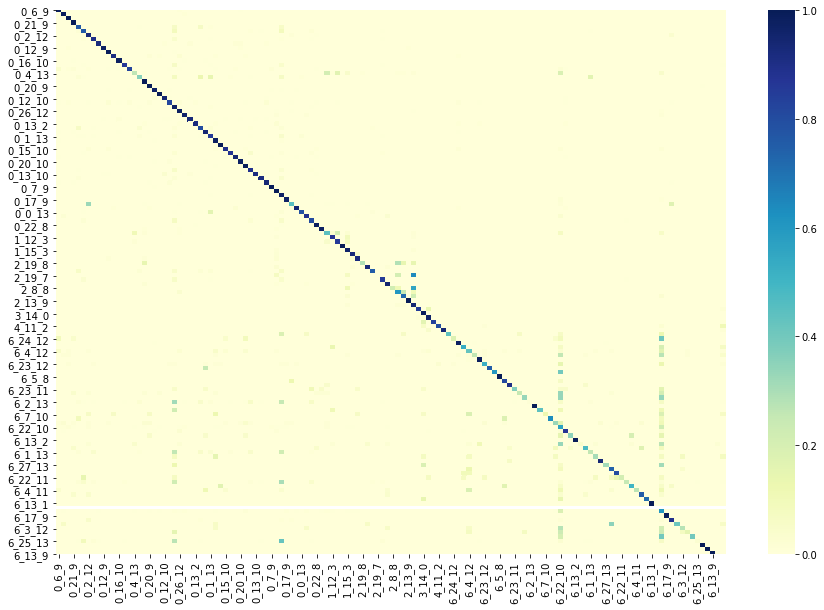

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
df,accuracy = returnDF(train_corr_matrix)
print("accuracy",accuracy)
ig, ax = plt.subplots(figsize=(15,10))
#print(print(df['total']))
sns.heatmap(df.drop(['total'],axis = 1), ax = ax, cmap="YlGnBu")

/home/etiennew/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


accuracy 0.7793824701195219


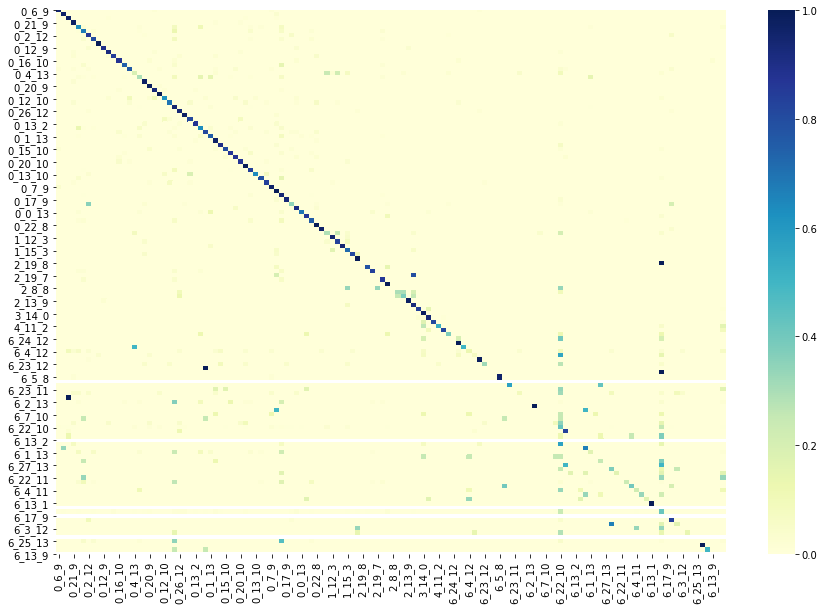

In [30]:
df,accuracy = returnDF(validation_corr_matrix)
print("accuracy",accuracy)
ig, ax = plt.subplots(figsize=(15,10))
#print(print(df['total']))
sns.heatmap(df.drop(['total'],axis = 1), ax = ax, cmap="YlGnBu")

/home/etiennew/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


accuracy 0.7852140077821012


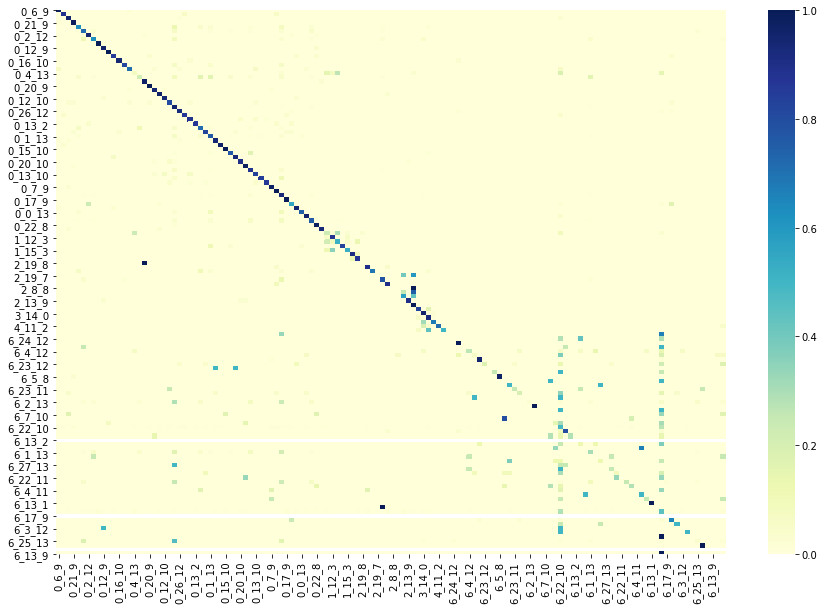

In [67]:
df,accuracy = returnDF(test_corr_matrix)
print("accuracy",accuracy)
ig, ax = plt.subplots(figsize=(15,10))
#print(print(df['total']))
sns.heatmap(df.drop(['total'],axis = 1), ax = ax, cmap="YlGnBu")